## Monte Carlo integration

An integration method for functions hard to get the analytical result.

### Related formulas

 $
 \begin{aligned}
 E[f(X)] &= \int{f(X)P_X(X)\ dX}\\
         &\approx \frac{1}{n}\sum_{i=0}^n f(x_i)
 \end{aligned}
 $
 
 $ Var(X) = E[(X-E[X]^2] = E[X^2]-E[X]^2 $
 
 special case for uniform distribution of samples:
 
 $ P_X(X) = \frac{1}{c} $
 
 $ \int_a^b{P_X(X)} = 1 $
 
 $ c = \frac{1}{b - a} $
 
 $
 \begin{aligned}
 E[f(X)] &= \int_a^b{f(X)P_X(X)\ dX}\\
         &\approx \frac{b - a}{n}\sum_{i=0}^n f(X_i)
 \end{aligned}
 $

In [6]:
import sympy
from sympy import *
import numpy as np

# Use MC to get result of integration of x^2 on (0, 3)

## Create the function
x= symbols('x')
f1 = x ** 2
interval = 3 - 0

analytical_int_f1 = integrate(f1)
ret1 = analytical_int_f1.subs(x, 3)
print('analytical result : ', ret1)

## Prepare uniform samples and stretch to dest region
uniform_samples = np.random.uniform(0, 1, 10000)
dest_samples = uniform_samples * 3

lambda_f1 = lambdify(x, f1 * interval, 'numpy')
ret_samples = lambda_f1(dest_samples)
ret2 = np.average(ret_samples)
print('mc result : ', ret2)

analytical result :  9
mc result :  8.959211126000982


## With importance sampling

By changing the formula a little bit, it could be rewrite as:

$
\begin{aligned}
E[f(x)] &= \int{f(x)p(x)dx}\\
        &= \int{(f(x) \frac{p(x)}{q(x)})\ q(x)dx}\\
        &\approx \frac{1}{n} \sum_i f(x_i) \frac{p(x_i)}{q(x_i)}
\end{aligned}
$

In [6]:
from sympy import *
import numpy as np

## Create the function
x = symbols('x')
f1 = x ** 2
lambda1_f1 = lambdify(x, f1, 'numpy')

pdf = x * 2 / 9 # Integrate to 1 on (0, 3)
lambda2_f1 = lambdify(x, f1 / pdf, 'numpy')

uniform_samples = np.random.uniform(0, 1, 1000)
power_samples = np.random.power(2, 1000)

# Get the integration on (0, 3)
ret1_samples = lambda1_f1(uniform_samples * 3)
ret1 = np.average(ret1_samples) * 3

ret2_samples = lambda2_f1(power_samples * 3)
ret2 = np.average(ret2_samples)

print('uniform distri : ', ret1)
print('power distri : ', ret2)

uniform distri :  8.75446315595295
power distri :  9.074928120183799


## The effect of importance sampling

By examining the variance changing, We'll see how importance is benefiting.
We'll also compare different the effect of different pdf.

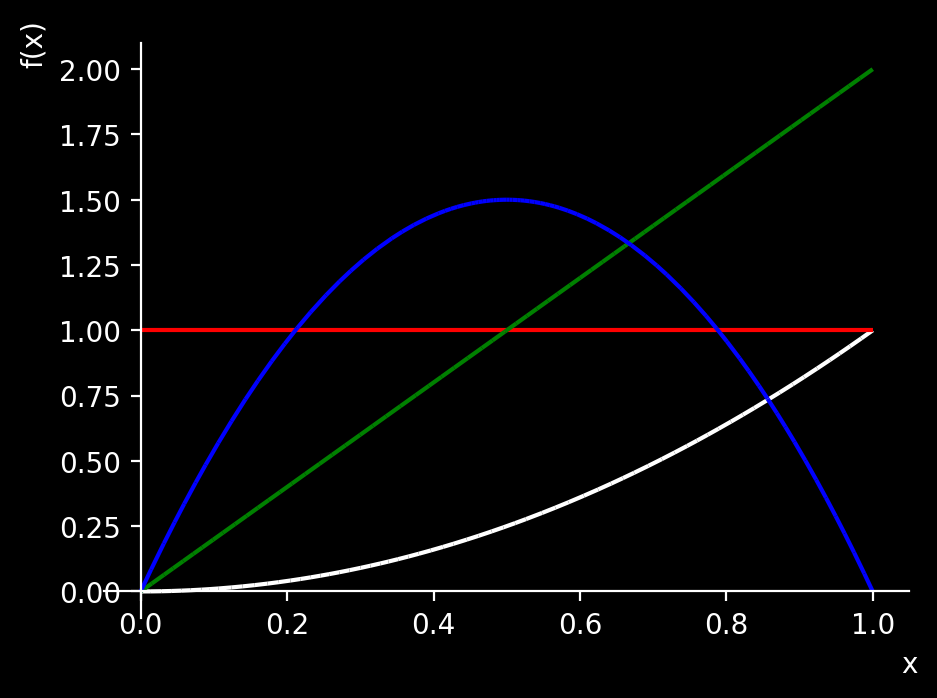

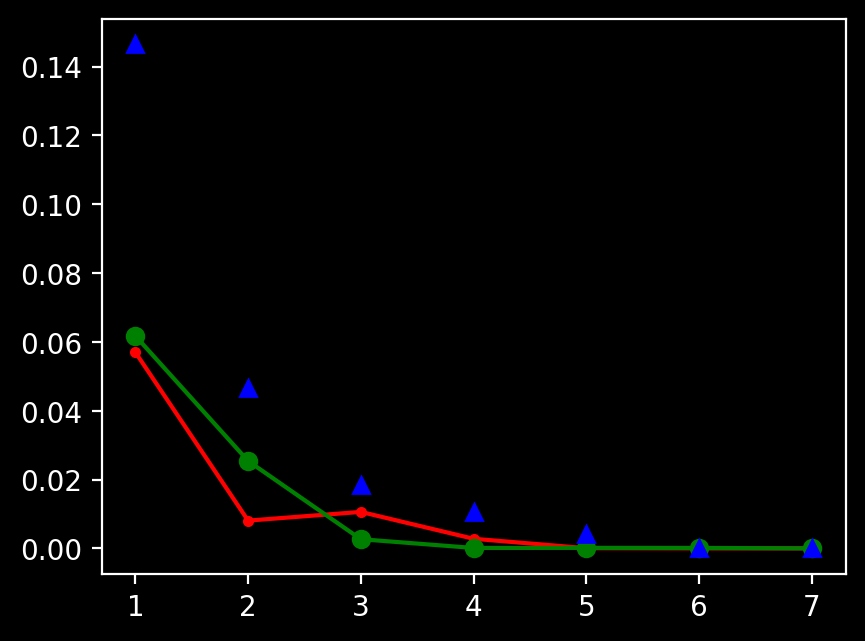

In [6]:
from sympy import *
from sympy.functions import exp
import numpy as np
import matplotlib.pyplot as plt
from sympy.plotting import plot

## Create the function
x = symbols('x')
f1 = x ** 2
lambda1_f1 = lambdify(x, f1, 'numpy')
normal_vars = []

# Power distribution
pdf1 = x * 2 # Integrate to 1 on (0, 1)
lambda2_f1 = lambdify(x, f1 / pdf1, 'numpy')
power_vars = []

# beta distribution with a = 2, b = 2
pdf2 = x * (1 - x) * 6
lambda3_f1 = lambdify(x, f1 / pdf2, 'numpy')
beta_vars = []

for i in range(1, 8):
    sample_cnt = 10 ** i
    uniform_samples = np.random.uniform(0, 1, sample_cnt)
    power_samples = np.random.power(2, sample_cnt)
    beta_samples = np.random.beta(2, 2, sample_cnt)

    # Get the integration on (0, 3)
    ret1_samples = lambda1_f1(uniform_samples)
    ret1 = np.average(ret1_samples)
    var1 = np.average(np.abs(ret1 - 1 / 3))
    normal_vars.append(var1)

    ret2_samples = lambda2_f1(power_samples)
    ret2 = np.average(ret2_samples)
    var2 = np.average(np.abs(ret2 - 1 / 3))
    power_vars.append(var2)

    ret3_samples = lambda3_f1(beta_samples)
    ret3 = np.average(ret3_samples)
    var3 = np.average(np.abs(ret3 - 1 / 3))
    beta_vars.append(var3)

    #print('ret1 : ', ret1, " var1 : ", var1)
    #print('ret2 : ', ret2, " var2 : ", var2)
    #print('ret3 : ', ret3, " var3 : ", var3)
    #print('')
    
p1 = plot(f1, (x, 0, 1), line_color='white', show=False)
p2 = plot(1, (x, 0, 1), line_color='red', show=False)
p3 = plot(pdf1, (x, 0, 1), line_color='green', show=False)
p4 = plot(pdf2, (x, 0, 1), line_color='blue', show=False)
p1.extend(p2)
p1.extend(p3)
p1.extend(p4)
p1.show()
x_coords = range(1, 8)
plt.plot(x_coords, normal_vars, 'r.-', x_coords, power_vars, 'go-', x_coords, beta_vars, 'b^')

 
## MIS

### Basic Approach

 1. Use multiple sampling techniques to do the sampling, use the weighted sum as the result.
 2. For complex integrand, you don't know which sampling technique is the best, MIS will perform much better than a bad match of sampling technique.
 3. Restriction 1: weight sum up to 1.
 4. Restriction 2: Weight equal to 0 where possibility is 0.
 
### Strategies of weighting function

 1. Balance heuristic:
 

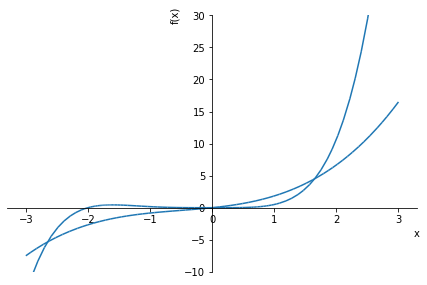

In [8]:
import sympy
from sympy import *
import numpy as np

x, y, f1, f2, if1, if2, fsum, fmul = symbols('x y f1 f2 if1 if2 fsum fmul')
pdf1, pdf2 = symbols('pdf1 pdf2')

f1 = x ** 2
f2 = x + 1

if1 = integrate(f1)
if2 = integrate(f2)

fsum = if1 + if2
fmul = if1 * if2

from sympy.plotting import plot

p1 = plot(fsum, (x, -3, 3), ylim=(-10, 30), show=False)
p2 = plot(fmul, (x, -3, 3), ylim=(-10, 30), show=False)

p1.extend(p2)

p1.show()

analytical result :  9
without importance result :  9.501497503064853
with importance result :  9.486711947970168


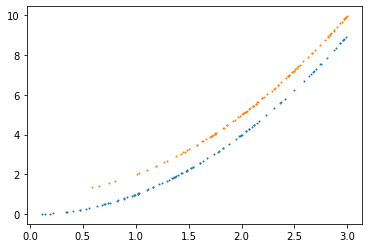

In [60]:
# Monte Carlo basics

from sympy import *
from sympy.stats import *
import numpy as np

x, y, z, f1, f2 = symbols('x y z f1 f2')

# Surpose f1 is a function hard to integrate
f1 = x ** 2
integrated_f1 = integrate(f1)
p1 = plot(integrated_f1, (x, 0, 5), show=False)
p2 = plot(f1, (x, 0, 5), show=False)
p1.extend(p2)
#p1.show()

print('analytical result : ', integrated_f1.subs(x, 3))

# Use Monte Carlo to evaluate integrate(x**2) in region (0, 3)

## Generate uniform samples
uniform_samples = np.random.uniform(0, 1, 100)

## Without importance sampling
lambda_f1 = lambdify(x, f1, 'numpy')
result_samples = lambda_f1(uniform_samples * 3)
result = np.average(result_samples) * 3
print('without importance result : ', result)

## Draw samples
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(uniform_samples * 3, result_samples, s=1)

## With importance sampling
### Three different pdf function to compare
pdf1, pdf2, pdf3 = symbols('pdf1 pdf2 pdf3')
### pdf must integrate to 1 in the dest region
pdf1 = 1 / 3
pdf2 = 2 * x / 9
pdf3 = x ** 2 / 9
cdf2 = integrate(pdf2)
cdf3 = integrate(pdf3)

### Currently havn't found any method to get the inversion
cdf2_inv = Pow(x * 9, 1 / 2)
cdf3_inv = Pow(x * 27, 1 / 3)

### Get customized distribution of samples
lambda_pdf = lambdify(x, cdf2_inv, 'numpy')
pdf_samples = lambda_pdf(uniform_samples)
lambda_est = lambdify(x, f1 / pdf2, 'numpy')
result_samples2 = lambda_est(pdf_samples)
result2 = np.average(result_samples2)
print('with importance result : ', result2)

remapped_samples = lambda_f1(pdf_samples)
plt.scatter(pdf_samples, remapped_samples + 1, s=1)